In [2]:
# --- 1) Import Libraries and set file paths for EDA ---
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# import zeyrek #TODO: later analyze for morphological features

sns.set_theme()
DATA_PATH = Path("../datasets/countries.json") # includes more than 10 country entries from eksisozluk



[nltk_data] Downloading package stopwords to /home/zk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
target_urls = [
  "https://eksisozluk.com/fransa--46687",
  "https://eksisozluk.com/rusya--43748",
  "https://eksisozluk.com/cin--2099924",
  "https://eksisozluk.com/kanada--58585",
  "https://eksisozluk.com/suudi-arabistan--128684",
  "https://eksisozluk.com/yunanistan--39870",
  "https://eksisozluk.com/sili--64696",
  "https://eksisozluk.com/ermenistan--111737",
  "https://eksisozluk.com/iran--45394",
  "https://eksisozluk.com/israil--68980",
  "https://eksisozluk.com/somali--129500",
  "https://eksisozluk.com/cezayir--114173",
  "https://eksisozluk.com/kazakistan--55971",
  "https://eksisozluk.com/mogolistan--71457",
  "https://eksisozluk.com/lihtenstayn--385546",
  "https://eksisozluk.com/yeni-zelanda--86544",
  "https://eksisozluk.com/angola--167447",
  "https://eksisozluk.com/venezuela--61614",
  "https://eksisozluk.com/el-salvador--96743",
  "https://eksisozluk.com/vietnam--56902",
  "https://eksisozluk.com/japonya--50310",
  "https://eksisozluk.com/kuzey-kore--66320",
  "https://eksisozluk.com/guney-kore--62870",
  "https://eksisozluk.com/filistin--97065",
  "https://eksisozluk.com/ukrayna--80137",
  "https://eksisozluk.com/sirbistan--144150",
  "https://eksisozluk.com/gurcistan--91933",
  "https://eksisozluk.com/makedonya--93047",
  "https://eksisozluk.com/bosna-hersek--127685",
  "https://eksisozluk.com/isvicre--35513",
  "https://eksisozluk.com/irak--55600",
  "https://eksisozluk.com/kurdistan--240029",
  "https://eksisozluk.com/kibris--36897",
  "https://eksisozluk.com/suriye--57388",
  "https://eksisozluk.com/pakistan--42073",
  "https://eksisozluk.com/hindistan--42072"
]

In [4]:
# --- 2) Extract the numeric ids from each URL ---

TARGET_IDS = [url.split("--")[-1] for url in target_urls]
print(f'Target IDs: {TARGET_IDS}')

Target IDs: ['46687', '43748', '2099924', '58585', '128684', '39870', '64696', '111737', '45394', '68980', '129500', '114173', '55971', '71457', '385546', '86544', '167447', '61614', '96743', '56902', '50310', '66320', '62870', '97065', '80137', '144150', '91933', '93047', '127685', '35513', '55600', '240029', '36897', '57388', '42073', '42072']


In [5]:
# --- 3) Load JSON data from file and verify successful loading ---
with DATA_PATH.open() as f:
    raw = json.load(f)
    if not raw:
        raise ValueError("Failed to load JSON data from file.")
    else:
        print("JSON data loaded successfully.")


JSON data loaded successfully.


In [6]:
# --- 4) Explore the top-level structure of the JSON data ---
raw = {tid: blob for tid, blob in raw.items() if tid in TARGET_IDS}
print(f'Filtered raw data to include only target IDs. The length: {len(raw)}')


Filtered raw data to include only target IDs. The length: 36


In [7]:
# --- 5) Structure and Sample Data Inspection ---

records = []

for topic_id, topic_blob in raw.items():
    topic_meta = topic_blob.get("topic", {})
    entries = topic_blob.get("entries", [])
    
    for entry in entries:
        row = {
            'topic_id': topic_id,
            'topic_title': topic_meta.get('title', ''),
            'topic_url': topic_meta.get('url', ''),
            'entry_count_reported': topic_meta.get('entry_count_reported', 0),
            'entry_id': entry.get('id', ''),
            'author': entry.get('author', ''),
            'favorites': entry.get('favorites', 0),
            'created_at': entry.get('created_at', ''),
            'created_at_raw': entry.get('created_at_raw', 0),
            'text': entry.get('text', ''),
            'entry_url': entry.get('url', '')
            
        }
        records.append(row)
        
df =pd.DataFrame(records)
print(f'DataFrame shape: {df.shape}')
print(df.head())

DataFrame shape: (57470, 11)
  topic_id topic_title                             topic_url  \
0    46687      fransa  https://eksisozluk.com/fransa--46687   
1    46687      fransa  https://eksisozluk.com/fransa--46687   
2    46687      fransa  https://eksisozluk.com/fransa--46687   
3    46687      fransa  https://eksisozluk.com/fransa--46687   
4    46687      fransa  https://eksisozluk.com/fransa--46687   

   entry_count_reported entry_id    author  favorites           created_at  \
0                     0               tazz          0  1999-11-07T18:59:00   
1                     0              encre          0                 None   
2                     0            suicyco          0  2000-05-30T21:54:00   
3                     0               down          0                 None   
4                     0           chuinase          0  2002-04-18T12:24:00   

                        created_at_raw  \
0                     07.11.1999 18:59   
1  20.05.2000 19:17 ~ 19.11.2003 

In [8]:
# --- 6) Inspect Structure and Missing Values ---

df.info()
df.isna().mean().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57470 entries, 0 to 57469
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   topic_id              57470 non-null  object
 1   topic_title           57470 non-null  object
 2   topic_url             57470 non-null  object
 3   entry_count_reported  57470 non-null  int64 
 4   entry_id              57470 non-null  object
 5   author                57470 non-null  object
 6   favorites             57470 non-null  int64 
 7   created_at            42677 non-null  object
 8   created_at_raw        57470 non-null  object
 9   text                  57470 non-null  object
 10  entry_url             57470 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.8+ MB


created_at              0.257404
topic_id                0.000000
topic_title             0.000000
topic_url               0.000000
entry_count_reported    0.000000
entry_id                0.000000
author                  0.000000
favorites               0.000000
created_at_raw          0.000000
text                    0.000000
entry_url               0.000000
dtype: float64

In [9]:
# --- 7) Basic Statistical Summary ---
print("entries:", df.shape[0])
print("topics:", df["topic_id"].nunique())
print("authors:", df["author"].nunique())
print("duplicate entry_ids:", df["entry_id"].duplicated().sum())

df["text_len"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()

df[["favorites", "text_len", "word_count"]].describe()


entries: 57470
topics: 36
authors: 19672
duplicate entry_ids: 57469


,favorites,text_len,word_count
count,57470.0,57470.000000,57470.000000
mean,0.0,598.140056,79.833043
std,0.0,1539.318133,204.043316
min,0.0,1.000000,1.000000
25%,0.0,104.000000,13.000000
50%,0.0,226.000000,30.000000
75%,0.0,538.000000,73.000000
max,0.0,81121.000000,10170.000000


In [10]:

# --- 8) Text Tokenization and Frequency Analysis ---

URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
TOKEN_PATTERN = re.compile(r"[a-züğışöçâîû]+(?:'[a-züğışöçâîû]+)?", re.IGNORECASE)
TURKISH_STOPWORDS = nltk.corpus.stopwords.words("turkish")

def clean_text(text: str) -> str:
    return URL_PATTERN.sub("", text.lower())

def tokenize(text: str):
    cleaned = clean_text(text)
    tokens = TOKEN_PATTERN.findall(cleaned)
    return [tok for tok in tokens if len(tok) > 2 and tok not in TURKISH_STOPWORDS]


tokens = df['text'].dropna().apply(tokenize)

unigram_counts = Counter(tok for toks in tokens for tok in toks)
bigram_counts = Counter( (toks[i], toks[i+1]) for toks in tokens for i in range(len(toks)-1) )
trigram_counts = Counter( (toks[i], toks[i+1], toks[i+2]) for toks in tokens for i in range(len(toks)-2) )
display(top_unigrams:=unigram_counts.most_common(20))
display(top_bigrams:=bigram_counts.most_common(20))
display(top_trigrams:=trigram_counts.most_common(20))

[('bir', 110677),
 ('ülke', 24734),
 ('olarak', 18731),
 ('kadar', 17650),
 ('olan', 16748),
 ('var', 16678),
 ('yok', 11754),
 ('sonra', 10570),
 ('değil', 10525),
 ('bile', 10438),
 ('israil', 10403),
 ('büyük', 9546),
 ('bkz', 9208),
 ('türkiye', 8839),
 ('rusya', 8090),
 ('devlet', 7930),
 ('kendi', 7411),
 ('iran', 6985),
 ('olduğu', 6984),
 ('son', 6600)]

[(('bir', 'ülke'), 3828),
 (('bir', 'şekilde'), 2104),
 (('büyük', 'bir'), 1777),
 (('olan', 'ülke'), 1764),
 (('başka', 'bir'), 1587),
 (('böyle', 'bir'), 1490),
 (('herhangi', 'bir'), 1284),
 (('bir', 'devlet'), 1231),
 (('olan', 'bir'), 1181),
 (('bir', 'yer'), 1080),
 (('aynı', 'zamanda'), 920),
 (('yeni', 'bir'), 907),
 (('olmak', 'üzere'), 846),
 (('bir', 'ülkedir'), 821),
 (('bir', 'gün'), 808),
 (('tek', 'bir'), 770),
 (('önemli', 'bir'), 755),
 (('ciddi', 'bir'), 741),
 (('suudi', 'arabistan'), 735),
 (('bir', 'kaç'), 722)]

[(('görsel', 'görsel', 'görsel'), 289),
 (('başta', 'olmak', 'üzere'), 185),
 (('twitter', 'kaynak', 'alıntı'), 182),
 (('olan', 'bir', 'ülke'), 176),
 (('ikinci', 'dünya', 'savaşı'), 174),
 (('dahil', 'olmak', 'üzere'), 167),
 (('bir', 'süre', 'sonra'), 165),
 (('amerika', 'birleşik', 'devletleri'), 160),
 (('bir', 'ülke', 'değil'), 157),
 (('hakkında', 'bir', 'analiz'), 119),
 (('kişi', 'başına', 'düşen'), 115),
 (('bir', 'ülke', 'olarak'), 108),
 (('merak', 'ettiğim', 'ülke'), 105),
 (('değil', 'aynı', 'zamanda'), 101),
 (('bir', 'devlet', 'olarak'), 95),
 (('kısa', 'bir', 'süre'), 90),
 (('başka', 'bir', 'ülke'), 83),
 (('büyük', 'bir', 'kısmı'), 82),
 (('kadar', 'büyük', 'bir'), 80),
 (('yas', 'yas', 'yas'), 79)]

In [11]:
# --- 9) URL Analysis ---
df["urls"] = df["text"].str.findall(r"https?://\S+|www\.\S+")
url_expanded = df.explode("urls")
top_domains = (
    url_expanded["urls"]
    .dropna()
    .str.extract(r"https?://(?:www\.)?([^/]+)", expand=False)  # Add expand=False to get Series
    .value_counts()
    .head(15)
)
display(top_domains)

urls
youtube.com               1016
politikaakademisi.org      676
twitter.com                642
bbc.com                    428
x.com                      357
youtu.be                   348
foreignaffairs.com         217
hurriyet.com.tr            174
thediplomat.com            154
en.wikipedia.org           154
dw.com                     142
foreignpolicy.com          140
tr.sputniknews.com         139
instagram.com              122
ydemokrat.blogspot.com     107
Name: count, dtype: int64

# Analysis of the Results

1) The Topics

- Our corpus is clearly geopolitical and international.

2) The Noise (Cleaning Issue)

- We detected many `bkz` which is abreviation for `bakınız`, that are common in eksi.
- Repeated 3-grams (e.g., 'görsel' 'görsel' 'görsel') shows filler captions exist

3) Stop Word Problem

- nltk for Turkish performs weak in terms of indulging clean corpus. 
- These polluting effects can be seen on n-gram analysis.
- We need custom stopword lists. F.e. `bir` shows in 110,000+ lines. 


In [12]:
# Extract the first date from the raw string
def parse_date(date_str):
    try:
        # Try with time format first
        return pd.to_datetime(date_str.split(' ~ ')[0], format='%d.%m.%Y %H:%M')
    except ValueError:
        # If that fails, try date-only format
        return pd.to_datetime(date_str.split(' ~ ')[0], format='%d.%m.%Y')

df['created_at_clean'] = df['created_at_raw'].apply(parse_date)
df = df.set_index('created_at_clean').sort_index()

# Verify the conversion
print("Earliest date:", df.index.min())
print("Latest date:", df.index.max())

Earliest date: 1999-07-01 00:00:00
Latest date: 2025-10-18 02:06:00


In [13]:
# --- Patterns ---
URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
BKZ_PATTERN = re.compile(r"\bbkz[:.]?\s*", flags=re.IGNORECASE)
REPEATED_GORSEL = re.compile(r"(görsel[\s,;/]*){2,}", flags=re.IGNORECASE)
MULTISPACE = re.compile(r"\s+")


APOSTROPHE_MAP = str.maketrans({
    "’": "'",
    "‘": "'",
    "`": "'",
    "´": "'",
    "‛": "'",
})

TOKEN_PATTERN = re.compile(
    r"[a-zğüşöçıîâû]+(?:'[a-zğüşöçıîâû]+)?",
    flags=re.IGNORECASE,
)
# --- Stopword management ---
BASE_STOPWORDS = {
    # seed list (can import from nltk if desired)
    "acaba","ama","ancak","artık","aslında","ayrıca","bana","bazı","belki","ben",
    "benden","beni","benim","bile","bir","birkaç","birçok","biri","birkaç","birşey",
    "biz","bizden","bizi","bizim","bu","buna","bunda","bunlar","bunları","bunların",
    "bunu","bunun","da","daha","de","defa","diğer","diğerleri","diye","dolayı","elbette",
    "en","fakat","gibi","hem","hep","hepsi","her","herkes","hiç","için","ile","ise","ister",
    "kadar","keşke","ki","kim","kimse","lütfen","mı","mi","mu","mü","nasıl","ne","neden",
    "nedenle","nerde","nerede","nereden","nereye","niye","o","olan","olarak","oldu",
    "olduğu","olsa","olup","ona","ondan","onlar","onları","onların","onu","onun","öyle",
    "sanki","sen","senden","seni","senin","siz","sizden","sizi","sizin","şayet","şimdi",
    "şöyle","şu","şuna","şunda","şunlar","şunu","şunun","tarafından","ve","veya","ya","yani",
    "yapılan","yapmak","yapılmış","yapıyor","yapılan","yani","yapılmak","yok", "çok","çünkü",
    "bir", "iki", "üç", "dört", "beş", "altı", "yedi", "sekiz", "dokuz", "on", "var", "nin", "nın",
    "şey", "şeyi", "şeyi", "şeyler", "şeyleri", "şeylerin", "eğer", "ise", "değil", "göre", "gibi", "bi"
    
}
DOMAIN_STOPWORDS = {
    "ülke","devlet","dünya","insan","millet","hükümet","biraz","böyle","aynen","artık","gerçekten"
}
KEEP_WORDS = {"kürt", "ermeni"}  # extend with terms you never want removed

STOPWORDS = (BASE_STOPWORDS | DOMAIN_STOPWORDS) - KEEP_WORDS

TOKEN_PATTERN = re.compile(r"[a-zğüşöçıîâû]+(?:'[a-zğüşöçıîâû]+)?", flags=re.IGNORECASE)

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = URL_PATTERN.sub(" ", text)
    text = BKZ_PATTERN.sub(" ", text)
    text = REPEATED_GORSEL.sub(" ", text)
    text = MULTISPACE.sub(" ", text)
    return text.strip()

def tokenize(text: str):
    cleaned = clean_text(text)
    tokens = TOKEN_PATTERN.findall(cleaned)
    return [tok for tok in tokens if len(tok) > 2 and tok not in STOPWORDS]

# Apply tokenization
tokens = df['text'].dropna().apply(tokenize)

# Rest of the analysis
unigram_counts = Counter(tok for toks in tokens for tok in toks)
bigram_counts = Counter((toks[i], toks[i+1]) for toks in tokens for i in range(len(toks)-1))
trigram_counts = Counter((toks[i], toks[i+1], toks[i+2]) for toks in tokens for i in range(len(toks)-2))


/tmp/ipykernel_4079547/968734891.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_4079547/968734891.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_4079547/968734891.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_4079547/968734891.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_4079547/968734891.py:42: FutureWa

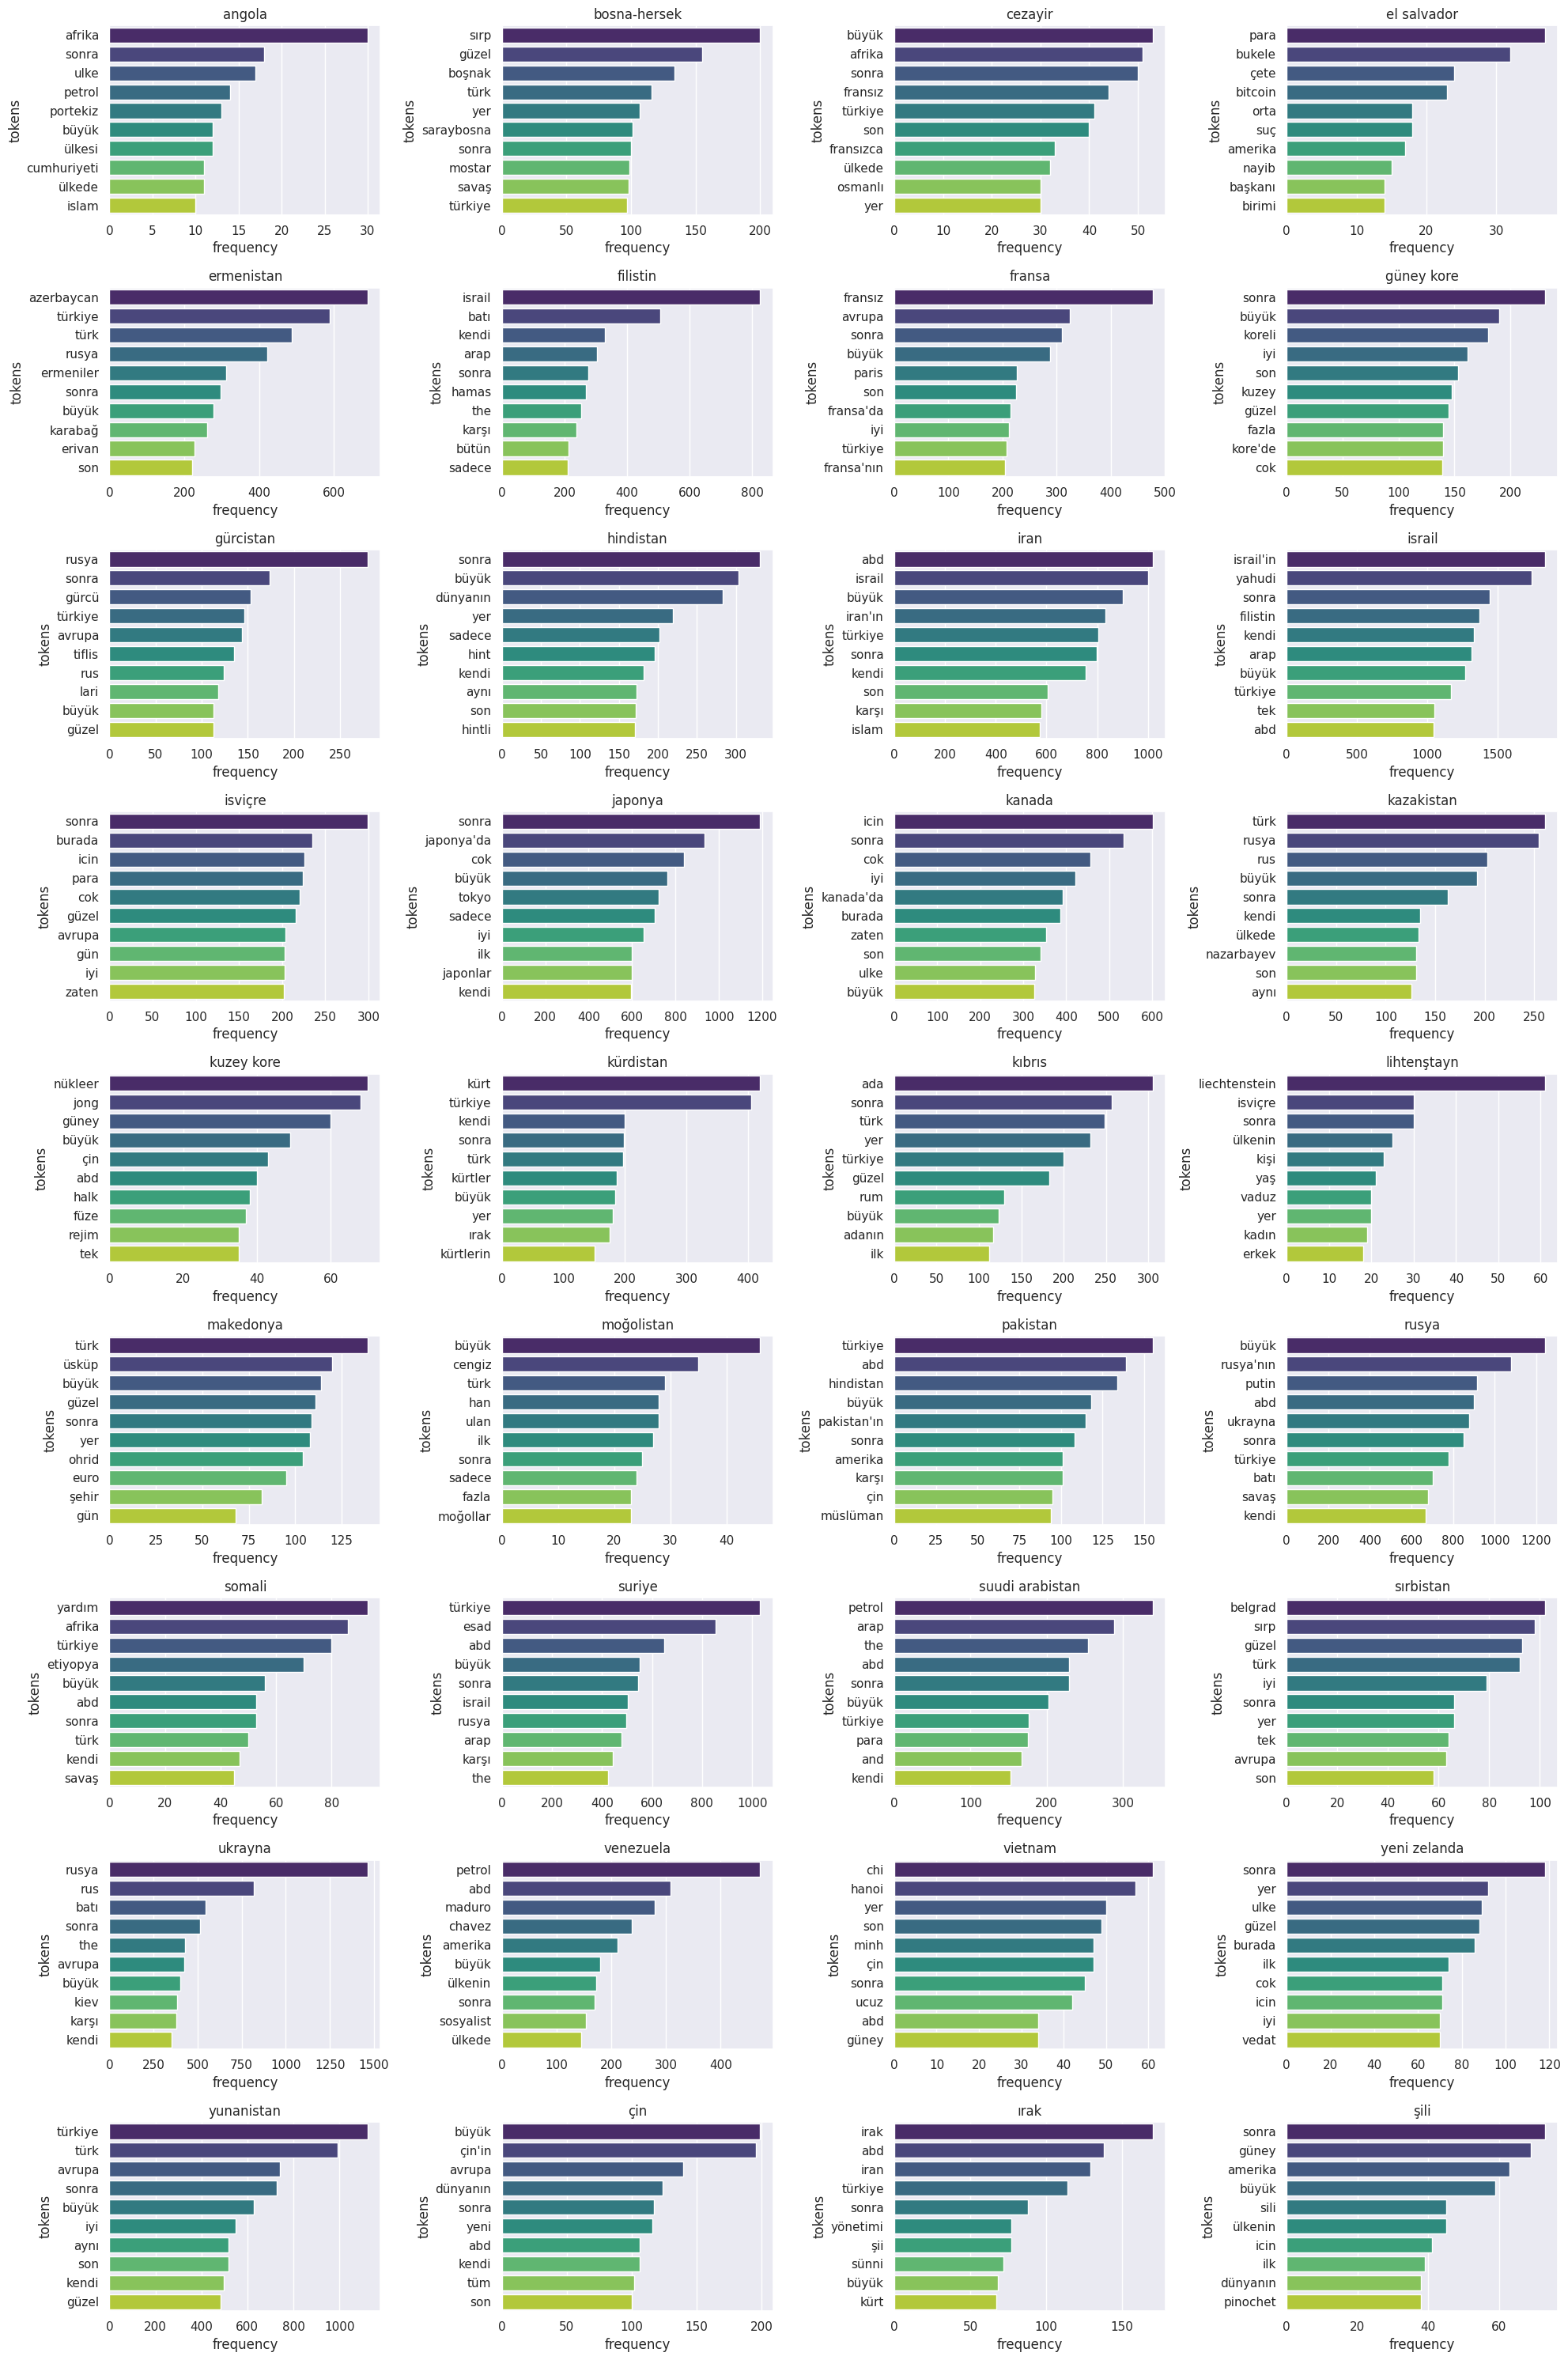

In [14]:
topic_tokens = (
    df.assign(tokens=tokens)  # tokens from the cleaned tokenizer map
      .explode("tokens")
      .dropna(subset=["tokens"])
)

# Top n tokens per topic
top_tokens_by_topic = (
    topic_tokens.groupby(["topic_title", "tokens"])
                .size()
                .rename("count")
                .reset_index()
)

# Konu başlıklarını küçük harfe çevirip filtreleme yapalım
top_tokens_by_topic_filtered = (
    top_tokens_by_topic[~top_tokens_by_topic.apply(
        lambda x: x['tokens'] in x['topic_title'].lower(), axis=1
    )]
)

top10_each = (
    top_tokens_by_topic_filtered
    .sort_values(["topic_title", "count"], ascending=[True, False])
    .groupby("topic_title")
    .head(10)
)

# Visualize: Grid layout for topics
def plot_top_tokens_grid(top_tokens_df, ncols=4, figsize=(20, 30)):
    # Calculate required number of rows
    n_topics = len(top_tokens_df['topic_title'].unique())
    nrows = (n_topics + ncols - 1) // ncols  # Ceiling division
    
    # Create figure and axes grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Plot each topic
    for idx, (topic, group) in enumerate(top10_each.groupby("topic_title")):
        ax = axes[idx]
        sns.barplot(
            data=group,
            x="count",
            y="tokens",
            palette="viridis",
            ax=ax
        )
        ax.set_title(f"{topic}")
        ax.set_xlabel("frequency")
        
    # Remove empty subplots if any
    for idx in range(n_topics, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig

# Create and display the grid plot
fig = plot_top_tokens_grid(top10_each)
plt.show()

In [15]:
import re
from itertools import chain
from collections import defaultdict
import scipy.sparse as sp
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.ticker import FormatStrFormatter
import cupy as cp
import cupyx.scipy.sparse as cpsp
from time import time


# ------------------------------------------------------------------
# 1. Ensure we’re using the latest token list (clean_text/STOPWORDS/tokenize defined earlier)
tokens = df["text"].fillna("").map(tokenize)
df = df.assign(tokens=tokens)

# ------------------------------------------------------------------
# 2. Build topic-level documents from tokens (no extra stopwords here)
topic_tokens = (
    df.groupby("topic_title")["tokens"]
      .apply(lambda series: list(chain.from_iterable(series)))
)

topic_docs = topic_tokens.map(lambda toks: " ".join(toks))

# ------------------------------------------------------------------
# 3. Collect country-name fragments to filter later
def normalize_country(title: str):
    return re.findall(r"[a-zğüşöçıîâû]+", title.lower())

COUNTRY_TERMS = set(chain.from_iterable(normalize_country(title) for title in topic_tokens.index))


# ------------------------------------------------------------------
# 4. Vectorise with TF-IDF using GPU acceleration
start_time = time()

# Initial vectorization (still on CPU as sklearn doesn't support GPU directly)
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x.split(),
    lowercase=False,
    min_df=2,  # Lower this from 5
    max_features=2000
)
X = vectorizer.fit_transform(topic_docs)
feature_names = vectorizer.get_feature_names_out()

# Move data to GPU
X_gpu = cpsp.csr_matrix(X)
valid_mask = cp.array([
    not any(cterm in term for cterm in COUNTRY_TERMS)
    for term in feature_names
])

# Perform filtering on GPU
valid_indices = cp.where(valid_mask)[0]
X_filtered = X_gpu[:, valid_indices]
feature_names = feature_names[cp.asnumpy(valid_mask)]

# Move results back to CPU for DataFrame creation
X_cpu = cp.asnumpy(X_filtered.toarray())
tfidf_df = pd.DataFrame(
    X_cpu,
    index=topic_docs.index,
    columns=feature_names
)

print(f"TF-IDF processing time: {time() - start_time:.2f} seconds")


# ------------------------------------------------------------------
# 5. Extract the top-N distinctive terms per topic
TOP_N = 7
top_per_topic = (
    tfidf_df.apply(lambda row: row.nlargest(TOP_N))
            .stack()
            .reset_index()
            .rename(columns={"level_1": "token", 0: "tfidf"})
)

# Optional: keep only strong signals
top_per_topic = top_per_topic[top_per_topic["tfidf"] > 0]
# Add this before plot_tfidf_topics
print("Number of topics:", len(top_per_topic['topic_title'].unique()))
print("Value counts per topic:")
print(top_per_topic['topic_title'].value_counts())




/home/zk/miniconda3/envs/nlp.env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF processing time: 1.63 seconds
Number of topics: 36
Value counts per topic:
topic_title
moğolistan         648
hindistan          615
şili               611
isviçre            581
sırbistan          568
el salvador        523
lihtenştayn        518
angola             513
fransa             513
yeni zelanda       458
kanada             451
kazakistan         417
gürcistan          410
yunanistan         381
suudi arabistan    367
çin                358
japonya            334
filistin           324
kıbrıs             321
kürdistan          309
pakistan           305
vietnam            292
suriye             287
ırak               283
rusya              281
makedonya          281
güney kore         270
israil             262
cezayir            236
ukrayna            192
ermenistan         181
kuzey kore         180
venezuela          173
iran               152
somali             119
bosna-hersek       102
Name: count, dtype: int64


In [16]:
import plotly.express as px

# İlk 10 ülkeyi alalım
top10 = (top_per_topic
         .groupby('topic_title')['tfidf']
         .sum()
         .nlargest(10)
         .index)

# Her ülke için top terimlerini hazırlayalım
race_df = (top_per_topic
           .query("topic_title in @top10")
           .sort_values(['topic_title', 'tfidf'], ascending=[True, False])
           .groupby('topic_title')
           .head(15)  # Her ülkeden top 15 terim
           .reset_index(drop=True))

# Max TF-IDF değerini bulalım (x ekseni için)
max_tfidf = race_df['tfidf'].max()

fig = px.bar(race_df,
             x='tfidf', 
             y='token', 
             color='topic_title',
             animation_frame='topic_title',
             orientation='h',
             height=600,
             title='Ülke Bazlı Öne Çıkan Terimler (Otomatik Sıralı Bar)',
             color_discrete_sequence=px.colors.qualitative.Bold,
             range_x=[0, max_tfidf * 1.1])  # %10 margin

# Her frame'de y eksenini sıralı tutmak için
fig.update_yaxes(categoryorder='total ascending')

fig.show()



In [17]:
from itertools import chain
from textwrap import fill

# 1. Build the topic documents from your cleaned tokens
tokens = df["text"].fillna("").map(tokenize)
df = df.assign(tokens=tokens)

topic_docs = (
    df.groupby("topic_title")["tokens"]
      .apply(lambda series: list(chain.from_iterable(series)))
      .map(lambda toks: " ".join(toks))
)

# 2. Compute TF-IDF
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=False, min_df=5, max_features=1000)
X = vectorizer.fit_transform(topic_docs)
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame.sparse.from_spmatrix(
    X,
    index=topic_docs.index,
    columns=vectorizer.get_feature_names_out()
)

# 3. Extract top terms per topic and format as text
TOP_N = 8
def topic_top_terms(row):
    top = row.nlargest(TOP_N)
    return [
        f"{token} ({score:.3f})"
        for token, score in top.items()
    ]

summary = (
    tfidf_df.apply(topic_top_terms, axis=1)
            .rename("top_tokens")
            .reset_index()
)

# 4. Display as text blocks (no plots)
for _, record in summary.iterrows():
    tokens_text = ", ".join(record["top_tokens"])
    print(f"• {record['topic_title']}: {fill(tokens_text, width=80)}\n")


/home/zk/miniconda3/envs/nlp.env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



• angola: afrika (0.411), sonra (0.215), ulke (0.203), petrol (0.187), büyük (0.144),
ülkesi (0.144), islam (0.133), cumhuriyeti (0.132)

• bosna-hersek: bosna (0.843), güzel (0.129), türk (0.097), yer (0.089), sonra (0.083), savaş
(0.082), türkiye (0.081), büyük (0.076)

• cezayir: afrika (0.246), büyük (0.223), fransız (0.218), sonra (0.211), türkiye (0.173),
son (0.169), fransa (0.144), osmanlı (0.141)

• el salvador: para (0.391), amerika (0.195), orta (0.190), başkanı (0.148), büyük (0.148), son
(0.148), ülkede (0.127), şekilde (0.127)

• ermenistan: ermenistan (0.638), ermeni (0.371), azerbaycan (0.310), türkiye (0.190), türk
(0.157), rusya (0.155), sonra (0.096), büyük (0.090)

• filistin: filistin (0.567), israil (0.406), hamas (0.217), batı (0.211), filistinli
(0.140), arap (0.131), kendi (0.131), sonra (0.109)

• fransa: fransa (0.549), fransız (0.284), avrupa (0.165), sonra (0.157), büyük (0.146),
son (0.114), almanya (0.111), iyi (0.107)

• güney kore: kore (0.696), güney (